In [1]:
import tifffile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
from skimage import measure
from skimage.measure import regionprops

pip install fill-voids

In [2]:
def read_sequence(folder_path):
    """
    Read a sequence of TIFF files in a folder as a 3D volume.
    
    Args:
    folder_path (str): Path to the folder containing TIFF files.

    Returns:
    numpy.ndarray: A 3D array where each slice corresponds to a TIFF file.
    """

    # List and sort the TIFF files
    tiff_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if (f.endswith('.tiff') or f.endswith('.tif'))])

    tiff_sequence = tifffile.TiffSequence(tiff_files)
    
    # Get the total number of TIFF files
    total_files = len(tiff_files)
    
    # Read each TIFF file and update progress
    volume = []
    with tqdm(total=total_files, desc="Progress") as pbar:
        for i, file_path in enumerate(tiff_files):
            slice_data = tifffile.imread(file_path)
            volume.append(slice_data)
            
            # Update progress
            pbar.update(1)
    
    return np.array(volume)

In [3]:
from tqdm import tqdm
def write_sequence(folder_path, name, volume):
    """
    Save a 3D volume as a sequence of TIFF files in a folder.
    
    Args:
    folder_path (str): Path to the folder where TIFF files will be saved.
    name (str): Name of the TIFF files.
    volume (numpy.ndarray): A 3D array where each slice corresponds to an image.
    """

    folder_path = folder_path / name

    # Create the folder if it doesn't exist
    Path(folder_path).mkdir(parents=True, exist_ok=True)

    # Save each slice as a TIFF file with progress bar
    with tqdm(total=volume.shape[0], desc="Saving") as pbar:
        for i in range(volume.shape[0]):
            tifffile.imwrite(f"{folder_path}/{name}_{i:04d}.tif", volume[i])
            pbar.update(1)
    
    print("Saving complete.")

In [4]:
xct_file = Path(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Juan Ignacio\probetas\4\frontal_90right.tif')

xct = tifffile.imread(xct_file)

# xct = tifffile.imread(xct_folder / 'frontal_cropped.tif')

In [5]:
from skimage import filters

print('masking')

# Create a masked array, excluding zeros
masked_data = np.ma.masked_equal(xct, 0)

unmasked_data = masked_data.compressed()

print('computing otsu')

# Apply Otsu thresholding on the non-zero values
threshold_value = filters.threshold_otsu(unmasked_data)

print('thresholding with value: ', threshold_value)

binary = xct > threshold_value

masking
computing otsu
thresholding with value:  123


In [6]:
max_proj = np.max(binary, axis=0)

labels = measure.label(max_proj)

props = regionprops(labels)

minr, minc, maxr, maxc = props[0].bbox

#crop the volume

binary_cropped = binary[:, minr:maxr, minc:maxc]

In [36]:
def get_edge_labels(labeled_image):
    edge_labels = set()
    # Add labels from the edges
    edge_labels.update(labeled_image[0, :])  # Top edge
    edge_labels.update(labeled_image[-1, :])  # Bottom edge
    edge_labels.update(labeled_image[:, 0])  # Left edge
    edge_labels.update(labeled_image[:, -1])  # Right edge
    # Remove background label if present
    edge_labels.discard(0)
    return edge_labels

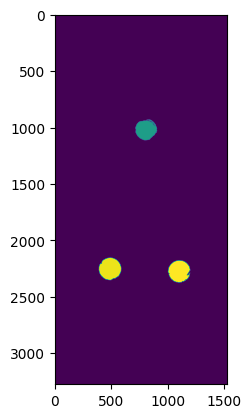

In [ ]:
max_proj = xct.max(axis=0)

max_proj_cropped = max_proj[minr:maxr, minc:maxc]

#otsu thresholding
threshold_value = filters.threshold_otsu(max_proj_cropped)

max_proj_cropped = max_proj_cropped <= threshold_value

max_proj_cropped_labeled = measure.label(max_proj_cropped)

edge_labels = get_edge_labels(max_proj_cropped_labeled)

for i in edge_labels:
    max_proj_cropped_labeled[max_proj_cropped_labeled == i] = 0

#regionprops
props = regionprops(max_proj_cropped_labeled)

#get the 3 biggest labels
props.sort(key=lambda x: x.area, reverse=True)

not_hole_labels = [x.label for x in props[3:]]

for i in not_hole_labels:
    max_proj_cropped_labeled[max_proj_cropped_labeled == i] = 0

plt.imshow(max_proj_cropped_labeled)

In [55]:
import fill_voids

sample_mask_cropped = np.zeros_like(binary_cropped)

for i in tqdm(range(binary_cropped.shape[0])):
    sample_mask_cropped[i] = fill_voids.fill(binary_cropped[i], in_place=False)

# sample_mask_cropped = fill_voids.fill(binary_cropped, in_place=False)

100%|██████████| 225/225 [00:20<00:00, 10.82it/s]


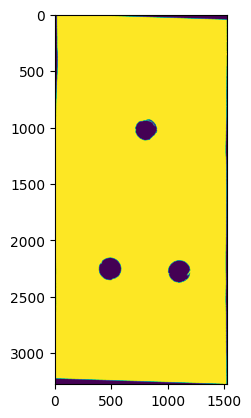

In [56]:
#sample mask without holes

for i in range(sample_mask_cropped.shape[0]):
    sample_mask_cropped[i][max_proj_cropped_labeled>0] = 0

plt.imshow(sample_mask_cropped.max(axis=0))

In [57]:
sample_mask = np.zeros_like(binary)
sample_mask[:, minr:maxr, minc:maxc] = sample_mask_cropped

In [58]:
#invert binary
binary_inverted = np.invert(binary)
onlypores = np.logical_and(binary_inverted, sample_mask)

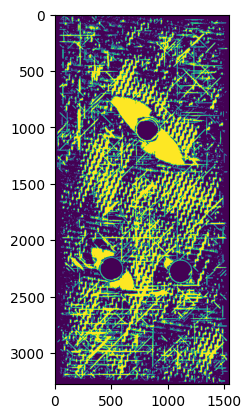

In [59]:
plt.imshow(onlypores.max(axis=0))

In [27]:
output_folder = xct_folder.parent / 'segmentation'

#save the segmented volume
write_sequence(output_folder, 'onlypores', onlypores.astype(np.uint8)*255)
#save the sample mask
write_sequence(output_folder, 'sample_mask', sample_mask.astype(np.uint8)*255)
#save the segmented volume
write_sequence(output_folder, 'binary', binary.astype(np.uint8)*255)

Saving: 100%|██████████| 350/350 [00:56<00:00,  6.19it/s]


Saving complete.


Saving: 100%|██████████| 350/350 [00:57<00:00,  6.12it/s]


Saving complete.


Saving: 100%|██████████| 350/350 [01:14<00:00,  4.71it/s]

Saving complete.
